## BRAIN TUMOR DETECTION

In [ ]:
# import dependencies
import os
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
no_dir = '/content/drive/MyDrive/brain tumor/BRAIN TUMOR DEEP L/no'
for filename in range(len(os.listdir(no_dir)) + 1) :
  no_values = np.zeros(filename)

In [ ]:
yes_dir = '/content/drive/MyDrive/brain tumor/BRAIN TUMOR DEEP L/yes'
for filename in range(len(os.listdir(yes_dir)) + 1) :
  yes_values = np.ones(filename)

In [ ]:
label = np.concatenate((no_values,yes_values))

In [ ]:
filenames = []
for names in os.listdir(no_dir):
  filenames.append('/content/drive/MyDrive/brain tumor/BRAIN TUMOR DEEP L/no/' + names )
for names in os.listdir(yes_dir) :
  filenames.append('/content/drive/MyDrive/brain tumor/BRAIN TUMOR DEEP L/yes/' + names )


In [ ]:
#check for unuique labels
unique_labels = np.unique(label)

In [ ]:
# converting labels to boolean values
boolean_labels = [item == unique_labels for item in label]

In [ ]:
# splitting into x & y
x = filenames
y = boolean_labels

In [ ]:
# splitting into training and test split
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size= 0.2,random_state=4)

len(x_train) , len(x_val) , len(y_train) , len(y_val)

(202, 51, 202, 51)

In [ ]:
# preprocess image
IMG_SIZE = 224


def preprocess(imagepath,img_size = IMG_SIZE):
  image = tf.io.read_file(imagepath)
  image = tf.image.decode_jpeg(image,channels = 3)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image,size= [IMG_SIZE,IMG_SIZE])
  return image


In [ ]:
# function to return tensor tuples in the form of (imagepath , label)
def get_image_label(imagepath,label) :
  image = preprocess(imagepath)
  return image,label

In [ ]:
# function to turn images into batches
BATCH_SIZE = 32

def create_batches(x,y = None,batch_size = BATCH_SIZE,test_data = False,val_data = False) :
  if test_data :
    print('creating test data batches ........................')
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = data.map(preprocess).batch(BATCH_SIZE)
    return data_batch
  elif val_data :
    print('creating valid data batches ......')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else :
    print('creating train data batches ...........................')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data = data.shuffle(buffer_size = len(x))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
train_data = create_batches(x_train,y_train)
val_data = create_batches(x_val,y_val,val_data = True)

creating train data batches ...........................
creating valid data batches ......


In [ ]:
val_data.element_spec , train_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

In [ ]:
#visualizing training and valida data
def show_25_images(images,label) :
  plt.figure(figsize = (10,10))
  for i in range(25) :
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[label[i].argmax()])
    plt.axis('off')

In [ ]:
# unbatching training data
train_img,train_labels = next(train_data.as_numpy_iterator())

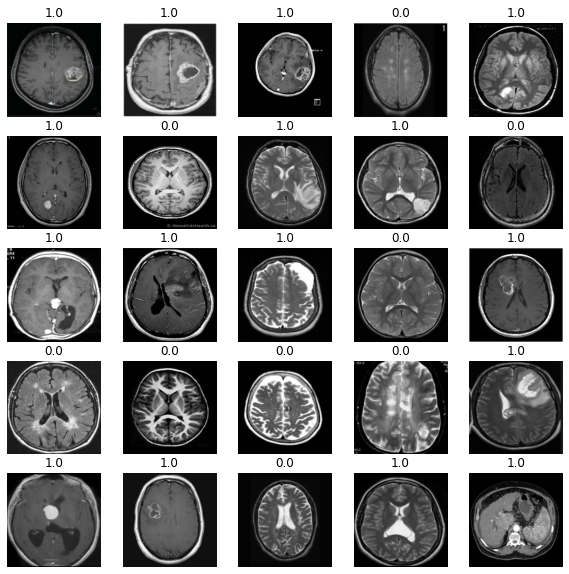

In [ ]:
show_25_images(train_img,train_labels) #training data

In [ ]:
#  unbatching validation data
val_img,val_labels = next(val_data.as_numpy_iterator())

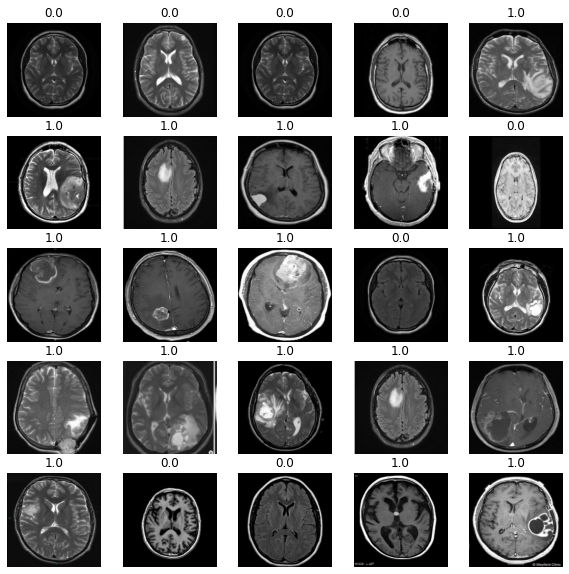

In [ ]:
show_25_images(val_img,val_labels) #valid data

## MODEL BUILDING

In [ ]:
# input shape
INPUT_SHAPE = [None,224,224,3]

#output shape 
OUTPUT_SHAPE = len(unique_labels)

model_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5' # setting up model url

In [ ]:
#create model
def create_model(INPUT_SHAPE = INPUT_SHAPE,OUTPUT_SHAPE = OUTPUT_SHAPE,MODEL_URL = model_url) :
  print(f'building model using {MODEL_URL}........................')
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      tf.keras.layers.Dense(
          units = OUTPUT_SHAPE,
          activation = 'sigmoid'
      )
  ])

  # compile model
  model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )

  #build
  model.build(INPUT_SHAPE)
  return model

In [ ]:
model = create_model()
model.summary()

building model using https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5........................
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 5,434,717
Trainable params: 2,004
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
# creating call backs

%load_ext tensorboard
import datetime

# creating a function for tensorboard
def create_tensorboard_callback() :
  logdir = os.path.join('/content/drive/MyDrive/brain tumor/BRAIN\ TUMOR\ DEEP\ L/gf',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3)

In [ ]:
def train_model() :
  model = create_model()

  tensorboard = create_tensorboard_callback()

  # fit model
  model.fit(
      x = train_data ,
      epochs = 10,
      validation_data = val_data,
      validation_freq = 1,
      callbacks = [tensorboard , early_stopping]
  )
  return model

In [ ]:
model = train_model()

building model using https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5........................
Epoch 1/10
7/7 [==============================] - 22s 1s/step - loss: 0.6889 - accuracy: 0.6436 - val_loss: 0.5522 - val_accuracy: 0.7843
Epoch 2/10
7/7 [==============================] - 1s 132ms/step - loss: 0.5031 - accuracy: 0.8218 - val_loss: 0.4505 - val_accuracy: 0.8824
Epoch 3/10
7/7 [==============================] - 1s 114ms/step - loss: 0.3909 - accuracy: 0.8614 - val_loss: 0.3774 - val_accuracy: 0.9020
Epoch 4/10
7/7 [==============================] - 1s 115ms/step - loss: 0.3463 - accuracy: 0.8614 - val_loss: 0.3423 - val_accuracy: 0.9216
Epoch 5/10
7/7 [==============================] - 1s 206ms/step - loss: 0.2997 - accuracy: 0.8960 - val_loss: 0.3411 - val_accuracy: 0.9216
Epoch 6/10
7/7 [==============================] - 1s 169ms/step - loss: 0.2789 - accuracy: 0.8911 - val_loss: 0.3023 - val_accuracy: 0.9216
Epoch 7/10
7/7 [=============================

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/brain tumor/BRAIN\ TUMOR\ DEEP\ L/gf

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

## making predictions

In [ ]:
predictions = model.predict(val_data)
predictions

2/2 [==============================] - 1s 23ms/step


array([[9.24743176e-01, 1.65516719e-01],
       [8.46667349e-01, 1.01065874e-01],
       [5.48211157e-01, 2.95654565e-01],
       [8.63529325e-01, 2.79961973e-01],
       [1.85539946e-01, 8.60966563e-01],
       [6.78485632e-02, 9.23328578e-01],
       [3.40781510e-01, 8.06513011e-01],
       [4.31177348e-01, 6.37926936e-01],
       [1.11281753e-01, 9.71515059e-01],
       [6.77030325e-01, 1.42851025e-01],
       [5.62779643e-02, 9.39245045e-01],
       [4.16223705e-02, 9.88363445e-01],
       [8.37777392e-04, 9.97090936e-01],
       [9.04020786e-01, 6.31004572e-01],
       [1.36856079e-01, 8.23929369e-01],
       [3.57661471e-02, 9.65434253e-01],
       [1.07832849e-01, 9.31505561e-01],
       [2.88133556e-03, 9.95827377e-01],
       [3.47760320e-01, 8.04633260e-01],
       [1.25614647e-02, 9.56631422e-01],
       [9.02838469e-01, 2.09633395e-01],
       [9.00154412e-01, 5.30956686e-01],
       [8.13717723e-01, 4.18624580e-01],
       [6.38413876e-02, 8.27860832e-01],
       [1.248052

In [ ]:
# unbatch val_data,so we can see images and compare them with predictions
def unbatch(data):
  images = []
  labels = []

  for image,label in data.unbatch().as_numpy_iterator() :
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])
  return images , labels


val_images , val_labels = unbatch(val_data)

In [ ]:
# plot to visualize predictions
def plot_preds(preds_proba , labels , images,n=4 ):
  pred_prob , true_label , image = preds_proba[n],labels[n],images[n]

  pred_label = unique_labels[np.argmax(pred_prob)]
  if pred_label == 0 :
    preds = 'NO TUMOR' 
  else:
    preds = 'TUMOR'

  if true_label == 0 :
    true = 'NO tUMOR'
  else :
    true = 'TUMOR'

  # plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # changes color when wrong
  if pred_label == true_label :
    color = 'green'
  else :
    color = 'red'
  

    # print title
  plt.title('Predicted : {} {:2.0f}% True label : {}'. format(preds,np.max(pred_prob)*100,true),color = color)

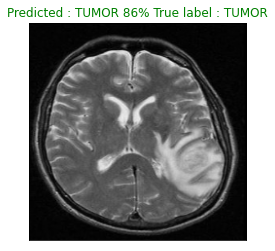

In [ ]:
plot_preds(preds_proba = predictions,labels = val_labels, images = val_img)

## CLASSIFICATION REPORT

In [ ]:

val_preds = unique_labels[np.argmax(predictions,axis = 1)]
import sklearn.metrics as metrics
val_trues =val_labels
from sklearn.metrics import classification_report
print(classification_report(val_trues, val_preds))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        20
         1.0       0.94      0.94      0.94        31

    accuracy                           0.92        51
   macro avg       0.92      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51



In [ ]:
#plot confusion matrics
def plot_conf(y_test,y_preds) :
  cm = metrics.confusion_matrix(y_test, y_preds)
  sns.heatmap(cm,annot = True)
  plt.xlabel('actual labels')
  plt.ylabel('predicted labels')

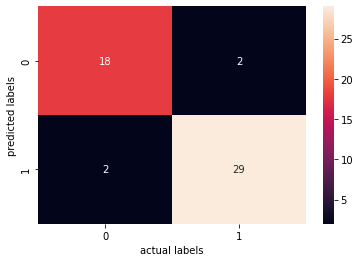

In [ ]:
plot_conf(val_trues,val_preds)

In [ ]:
## saving model
import os
from datetime import datetime
def save_model(model , suffix = None) :
  modeldir = os.path.join('/content/drive/MyDrive/brain tumor',datetime.now().strftime('%Y%m%d-%H%M%S'))
  modelpath = modeldir + '-' + suffix + '.h5'
  print(f'saving model into {modelpath}')
  model.save(modelpath)
  return modelpath


save_model(my_model,suffix = 'Brain_tumor_model')

['brain_tumor_model.joblib']